<a href="https://colab.research.google.com/github/Menbeo/robot/blob/main/LE_THI_PHUONG_QUYNH_CODE_INDIVIDUAL_TASK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate, gaussian_filter


In [ ]:
data1 = pd.read_csv('/content/lidar_positions_left.csv')
data = pd.read_csv('/content/lidar_positions_middle.csv')
data = pd.read_csv('/content/lidar_positions_right.csv')

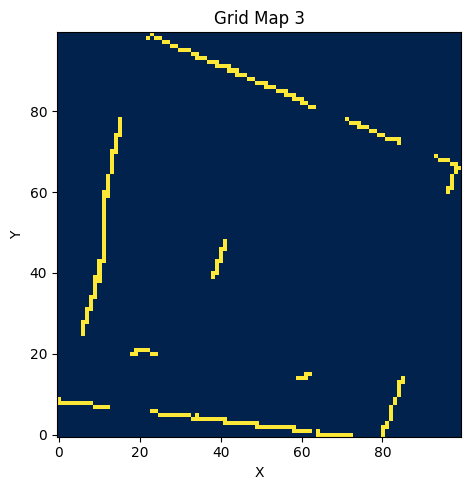

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generate_grid_map(file_name, grid_size=1.0, map_size=(100, 100)):
    # Load the data from the file
    data = data1 #input the data file in here (output of other positions will be provided in the docx file)
    x = data['x']
    y = data['y']

    # Scale x and y values to fit the grid size
    x_indices = ((x - x.min()) / (x.max() - x.min()) * (map_size[0] - 1)).astype(int)
    y_indices = ((y - y.min()) / (y.max() - y.min()) * (map_size[1] - 1)).astype(int)

    # Initialize grid map (z-values could be another column in your dataset, but here we use 0 for simplicity)
    grid = np.zeros(map_size)

    # Populate the grid map with values (you can set this to height values if you have 'z' in your data)
    for xi, yi in zip(x_indices, y_indices):
        if 0 <= xi < map_size[0] and 0 <= yi < map_size[1]:
            grid[xi, yi] = 1  # You can set it to a height value if you have 'z' in your data

    return grid

# Plotting setup
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
grid = generate_grid_map(data3)
axes.imshow(grid, cmap='cividis', origin='lower')
axes.set_title(f'Grid Map 3')
axes.set_xlabel('X')
axes.set_ylabel('Y')

plt.tight_layout()  # Corrected the typo
plt.show()


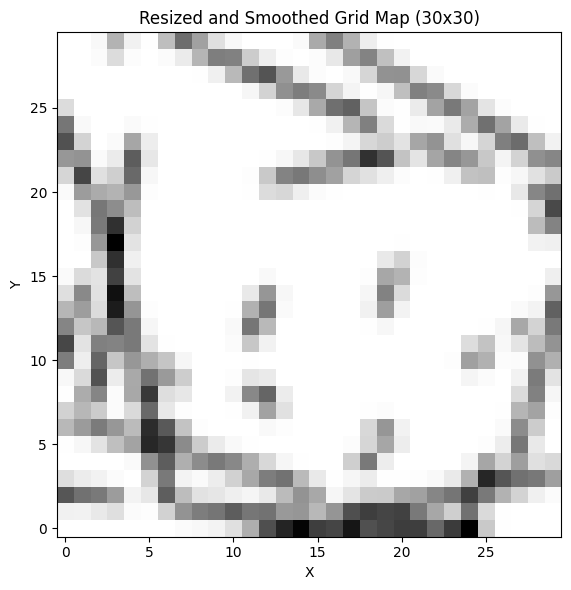

In [ ]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.transform import resize
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def generate_grid_map(file_name, map_size=(100, 100)):
    data = pd.read_csv(file_name)
    x = data['x'].values
    y = data['y'].values

    # Scale x and y values to fit the grid indices
    x_indices = ((x - x.min()) / (x.max() - x.min()) * (map_size[0] - 1)).astype(int)
    y_indices = ((y - y.min()) / (y.max() - y.min()) * (map_size[1] - 1)).astype(int)

    # Initialize grid map
    grid = np.zeros(map_size)

    # Populate the grid map
    for xi, yi in zip(x_indices, y_indices):
        if 0 <= xi < map_size[0] and 0 <= yi < map_size[1]:
            grid[xi, yi] = 1  # Assign a value for the presence of data

    return grid

def transform_grid(grid, translation=(0, 0), rotation_angle=0, map_size=(100, 100)):
    # Create a new grid to handle translation
    translated_grid = np.zeros(map_size)
    x_shift, y_shift = translation

    # Adjust translation to stay within bounds
    x_start = max(0, x_shift)
    y_start = max(0, y_shift)

    x_end = min(map_size[0], map_size[0] + x_shift)
    y_end = min(map_size[1], map_size[1] + y_shift)

    grid_x_start = max(0, -x_shift)
    grid_y_start = max(0, -y_shift)
    grid_x_end = grid_x_start + (x_end - x_start)
    grid_y_end = grid_y_start + (y_end - y_start)

    # Fill translated grid within bounds
    translated_grid[x_start:x_end, y_start:y_end] = grid[grid_x_start:grid_x_end, grid_y_start:grid_y_end]

    # Rotate the grid by the specified angle
    rotated_grid = rotate(translated_grid, rotation_angle, reshape=False, order=1, mode='constant')

    return rotated_grid

def merge_grids(grids, transformations, map_size=(100, 100)):
    merged_grid = np.zeros(map_size)

    for grid, transform in zip(grids, transformations):
        # Apply transformations
        transformed_grid = transform_grid(
            grid,
            translation=transform['translation'],
            rotation_angle=transform['rotation'],
            map_size=map_size
        )

        # Merge grids using max operation
        merged_grid = np.maximum(merged_grid, transformed_grid)

    return merged_grid

# File paths for the grid maps
file_paths = ['/content/lidar_positions_left.csv', '/content/lidar_positions_right.csv', '/content/lidar_positions_middle.csv']

# Generate the grid maps
grids = [generate_grid_map(file_path) for file_path in file_paths]

# Define transformations (translation and rotation) for each grid
transformations = [
    {'translation': (0, 0), 'rotation': 0},         # First grid: no translation, no rotation
    {'translation': (10, 0), 'rotation': 15},       # Second grid: translate by (10, 0), rotate by 15 degrees
    {'translation': (0, 10), 'rotation': -15}       # Third grid: translate by (0, 10), rotate by -15 degrees
]

# Merge the grids into a single map
merged_grid = merge_grids(grids, transformations, map_size=(100, 100))

# Apply Gaussian smoothing
smoothed_grid = gaussian_filter(merged_grid, sigma=1)

# Downscale the grid to 30x30
resized_grid = resize(smoothed_grid, (30, 30), anti_aliasing=True)

# Plotting the result
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(resized_grid, cmap='binary', origin='lower')
ax.set_title('Resized and Smoothed Grid Map (30x30)')
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.tight_layout()
plt.show()


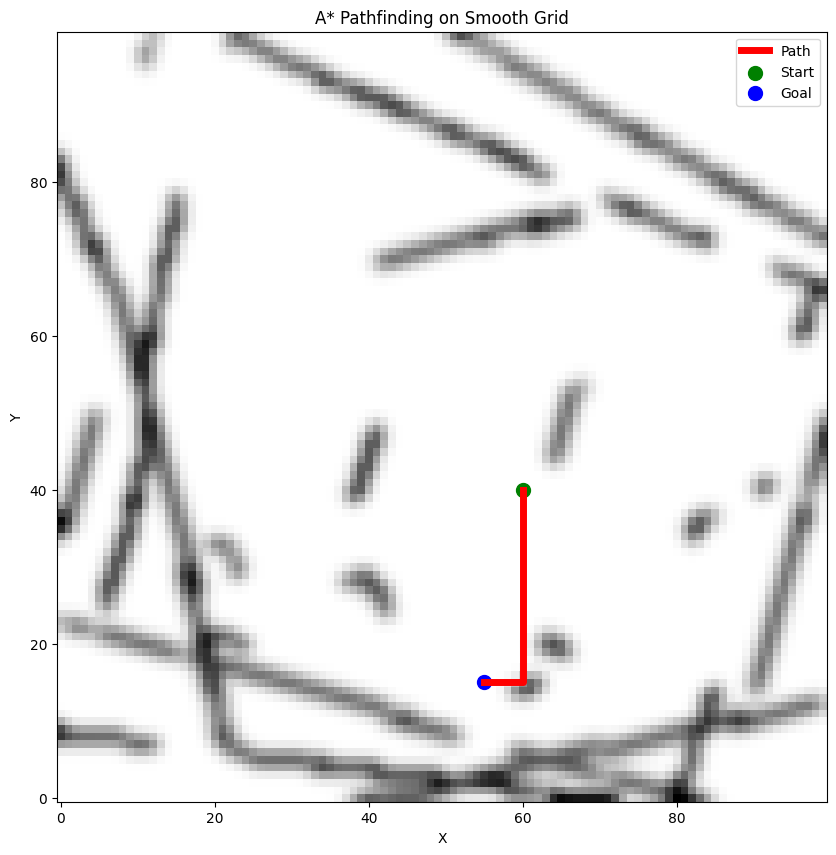

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import heapq

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star_algorithm(grid, start, goal):
    rows, cols = len(grid), len(grid[0])
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]

        x, y = current
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            neighbor = (x + dx, y + dy)
            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols:
                if grid[neighbor[0]][neighbor[1]] == 1:
                    continue

                tentative_g_score = g_score[current] + 1
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None
# Example binary grid for A* algorithm
binary_grid = np.zeros((100, 100), dtype=int)
binary_grid[smoothed_grid > 0.5] = 1  # Threshold for obstacles

# Define start and goal
start = (40, 60)  # (Y, X) in grid
goal = (15, 55)   # (Y, X) in grid

# Run A* algorithm
path = a_star_algorithm(binary_grid, start, goal)

# Plot the smooth grid and the path
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(smoothed_grid, cmap="binary", origin="lower", interpolation="none")
ax.set_title("A* Pathfinding on Smooth Grid")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Overlay the path if found
if path:
    path = np.array(path)
    ax.plot(path[:, 1], path[:, 0], color="red", linewidth= 5, label="Path")
    ax.scatter(start[1], start[0], color="green", label="Start", s=100)
    ax.scatter(goal[1], goal[0], color="blue", label="Goal", s=100  )
else:
    print("No path found")

ax.legend()
plt.show()
